In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2025-12-02 14:38:21.152006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 14:38:21.152140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 14:38:21.154486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-02 14:38:21.168875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def jsma(model, x, y=None, epochs:int=1, eps=1.0, clip_min=0.0, clip_max=1.0, score_fn=lambda t, o: t * tf.abs(o)):
    
    n = tf.shape(x)[0] # nombre d'images dans le batch

    target = tf.cond(tf.equal(0, tf.rank(y)),
                     lambda: tf.zeros([n], dtype=tf.int32) + y,
                     lambda: y)
    target = tf.stack((tf.range(n), target), axis=1) # normaliser, empiler les labels

    return _jsma_impl(model, x, target, epochs=epochs, eps=eps,
                    clip_min=clip_min, clip_max=clip_max, score_fn=score_fn)


In [4]:
def _jsma_impl(model, x, yind, y, epochs, eps, clip_min, clip_max, score_fn):

    def _cond(i, xadv):
        return tf.less(i, epochs)

    def _body(i, xadv):

        # dy_dx = tf.gradients(ybar, xadv)[0]
        # calcul du gradient de toutes les classes
        with tf.GradientTape() as tape:
            tape.watch(xadv)
            ybar = model(xadv, training=False)
        dy_dx = tape.gradient(ybar, xadv)


        # calcul du gradient de la classe cible uniquement
        #dt_dx = tf.gradients(yt, xadv)[0]
        with tf.GradientTape() as tape:
            tape.watch(xadv)
            ybar2 = model(xadv, training=False)
            yt = tf.gather_nd(ybar2, yind)
        dt_dx = tape.gradient(yt, xadv)

        # gradients of non-targets w.r.t input
        do_dx = dy_dx - dt_dx

        c0 = tf.logical_or(eps < 0, xadv < clip_max)
        c1 = tf.logical_or(eps > 0, xadv > clip_min)
        cond = tf.reduce_all([dt_dx >= 0, do_dx <= 0, c0, c1], axis=0)
        cond = tf.cast(cond, tf.float32)
        
        # saliency score for each pixel
        score = cond * score_fn(dt_dx, do_dx)

        shape = tf.shape(score)
        dim = tf.reduce_prod(shape[1:])
        score = tf.reshape(score, [-1, dim])

        # find the pixel with the highest saliency score
        ind = tf.argmax(score, axis=1)
        dx = tf.one_hot(ind, dim, on_value=eps, off_value=0.0)
        dx = tf.reshape(dx, shape)

        xadv = tf.stop_gradient(xadv + dx)
        xadv = tf.clip_by_value(xadv, clip_min, clip_max)

        return i+1, xadv

    #_, xadv = tf.while_loop(_cond, _body, (0, tf.identity(x)), back_prop=False, name='_jsma_batch')
    i = 0
    xadv = tf.identity(x) # when the predicted class change, we stop
    frequence_earystopping = 100
    while i < epochs:
        if i % frequence_earystopping == 0:
            r = model.predict(xadv, verbose=0)
            classe = np.argmax(r)
            if classe == y: break
        i, xadv = _body(i, xadv)
        
    return xadv

In [5]:
from keras.utils import to_categorical

(_, _), (x_batch, y_batch) = tf.keras.datasets.mnist.load_data()
xb = x_batch.astype('float32') / 255.0 #- 0.5
yb = to_categorical(y_batch, 10) # 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
# utilise plus loin, pour l'affichage du graphique 

x_batch = np.array([xb[10], xb[2], xb[1], xb[32], xb[4], xb[15], xb[21], xb[0], xb[61], xb[9]])
y_batch = np.array([yb[10], yb[2], yb[1], yb[32], yb[4], yb[15], yb[21], yb[0], yb[61], yb[9]])

normal_loader = tf.data.Dataset.from_tensor_slices((x_batch, y_batch)).batch(1)
model_logit = tf.keras.models.load_model('/work/mnist_classifier_model-no-softmax.h5')

2025-12-02 14:38:30.965329: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (34)


In [6]:
def make_jsma(model, X_data, y, epochs=100, eps=0.5, batch_size=1):

    # print('\nGenerating adversarial examples via JSMA (TF2)')
    
    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)
    
    for batch in range(n_batch):
        # print(f' Batch {batch + 1}/{n_batch}', end='\r')
        
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        batch_size_actual = end - start
        
        # Extraire le batch
        X_batch = tf.convert_to_tensor(X_data[start:end], dtype=tf.float32)
        
        # Gérer y correctement
        if isinstance(y, (int, np.integer)):
            y_batch = np.full(batch_size_actual, y, dtype=np.int32)
        else:
            y_batch = np.array(y[start:end], dtype=np.int32)
        
        # Créer yind
        yind = tf.stack([
            tf.range(batch_size_actual),
            tf.convert_to_tensor(y_batch, dtype=tf.int32)
        ], axis=1)

        # Lancer JSMA
        X_batch_adv = _jsma_impl(
            model=model,
            x=X_batch,
            yind=yind,
            y=y,
            epochs=epochs,
            eps=eps,
            clip_min=0.0,
            clip_max=1.0,
            score_fn=lambda t, o: t * tf.abs(o)
        )
        
        X_adv[start:end] = X_batch_adv.numpy()
    
    # print()
    return X_adv

Generating adversarial examples for each target class...

1/1 [==============================] - 0s 44ms/step
 proba: 6.21
1/1 [==============================] - 0s 47ms/step
 proba: 8.59
1/1 [==============================] - 0s 354ms/step
 proba: 15.36
1/1 [==============================] - 0s 40ms/step
 proba: 17.31
1/1 [==============================] - 0s 52ms/step
 proba: 5.21
1/1 [==============================] - 0s 33ms/step
 proba: 10.90
1/1 [==============================] - 0s 27ms/step
 proba: 6.00
1/1 [==============================] - 0s 47ms/step
 proba: 15.29
1/1 [==============================] - 0s 407ms/step
 proba: 8.61
1/1 [==============================] - 1s 831ms/step
 proba: 12.33

Generating figure


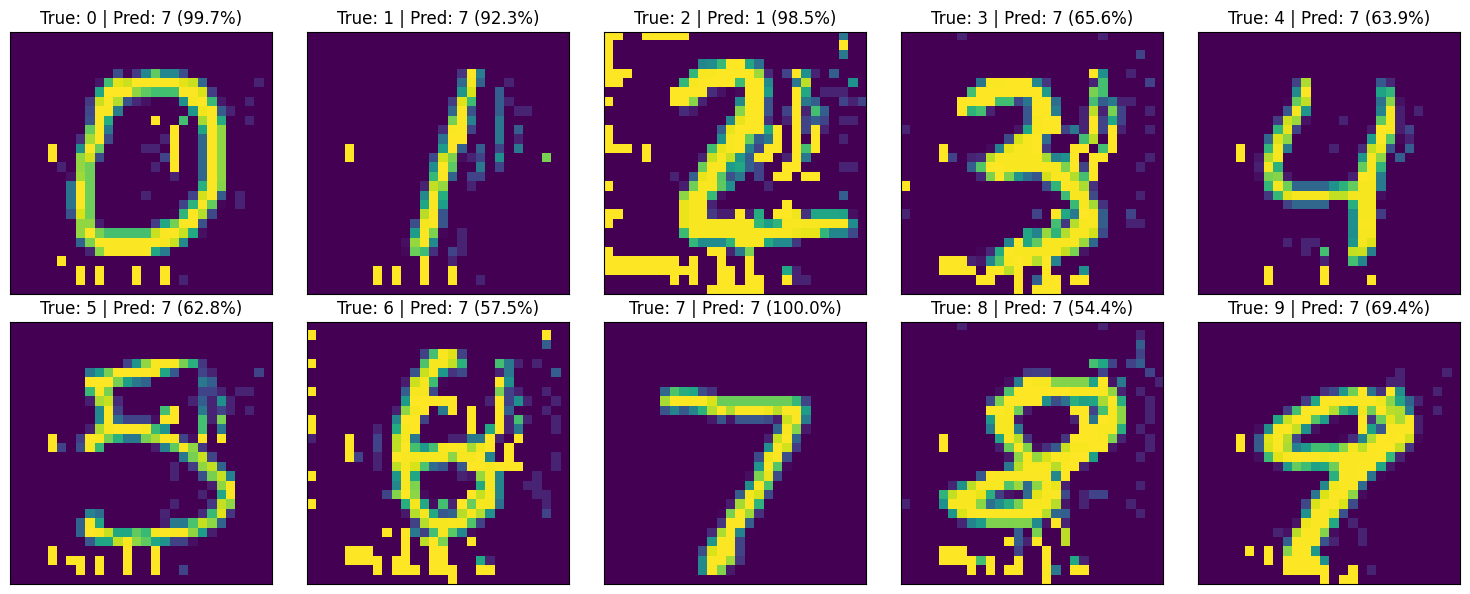

In [7]:
X_adv = np.empty((10, 28, 28), dtype=np.float32)
proba = np.empty((10, 10), dtype=np.float32)

print("Generating adversarial examples for each target class...\n")

for i in range(10):
    print(f'Target label {i}', end='', flush=True)
    
    # Générer l'adversariale
    xi = make_jsma(
        model=model_logit,
        X_data=x_batch[i].reshape(1, 28, 28, 1).astype(np.float32),
        y=7, # Classe cible
        epochs=2500,
        eps=0.1,
        batch_size=1
    )
    
    # print("shape", xi.shape)
    # print(f"Expected shape: {model_logit.input.shape}")
    yi = model_logit.predict(xi)
    X_adv[i] = np.squeeze(xi)
    proba[i] = np.squeeze(yi)
    print(f' proba: {np.max(proba[i]):.2f}')

print('\nGenerating figure')

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()  # Flatten pour accès facile
proba_normalized = tf.nn.softmax(proba).numpy()

for i in range(10):
    ax = axes[i]
    
    # Image adversariale
    bimg = np.copy(X_adv[i])
    
    # Afficher SANS binarisation (voir la gradation)
    im = ax.imshow(bimg)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Label amélioré
    predicted_class = np.argmax(proba[i])
    confidence = np.max(proba_normalized[i])*100
    
    ax.set_title(f'True: {np.argmax(y_batch[i])} | Pred: {predicted_class} ({confidence:.1f}%)')

plt.tight_layout()
plt.show()

# GRAPHIQUES

(commenté car cela prend du temps)

In [8]:
def accuracy_per_class(i, nb, v=False):
    eps_vals = [0.01, 0.02, 0.03, 0.05, 0.08, .1, .12, .15, .18, .2, .23,  .25]
    accuracy = []
    all_data = []  # Stocker les résultats complets
    
    for eps in eps_vals:
        eps *= -1 # negatif
        if v:
            print(eps, end=" ", flush=True)

        predictions_OK = 0
        X_adv_batch = np.empty((nb, 28, 28), dtype=np.float32)
        proba_batch = np.empty((nb, 10), dtype=np.float32)
        total = 0

        # Générer adversariales pour nb images différentes
        for image_idx in range(nb):    
            xi = make_jsma(
                model=model_logit,
                X_data=x_batch[image_idx + 10].reshape(1, 28, 28, 1).astype(np.float32),
                y=i,
                epochs=2000,
                eps=eps,
                batch_size=1
            )
            
            yi = model_logit.predict(xi, verbose=0)
            predicted_class = np.argmax(yi)
            
            # Stocker les résultats
            X_adv_batch[image_idx] = np.squeeze(xi)
            proba_batch[image_idx] = np.squeeze(yi)
            
            if predicted_class == i:
                predictions_OK += 1
            
            total += 1
        
        acc = 100 * predictions_OK / total
        accuracy.append(acc)
        
        # Stocker les données complètes pour cette eps
        all_data.append({
            'eps': eps,
            'accuracy': acc,
            'images': X_adv_batch,
            'probabilities': proba_batch,
            'success_count': predictions_OK
        })
    
    return eps_vals, accuracy, all_data

In [9]:
"""
res = []
for i in range(10):
    print(i, ':', end=" ")
    _, r, _ = accuracy_per_class(i, 15, v=True)
    res.append(r)
    print("\n", res[-1])
"""

'\nres = []\nfor i in range(10):\n    print(i, \':\', end=" ")\n    _, r, _ = accuracy_per_class(i, 15, v=True)\n    res.append(r)\n    print("\n", res[-1])\n'

In [10]:
"""
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot([0.01, 0.02, 0.03, 0.05, 0.08, .1, .12, .15, .18, .2, .23,  .25], res[i], label=f'Classe n°{i}')
plt.title("Précision en fonction d'ε")
plt.xlabel("ε")
plt.ylabel("Précision %")
plt.ylim(0, 105)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
"""

'\nplt.figure(figsize=(12, 6))\nfor i in range(10):\n    plt.plot([0.01, 0.02, 0.03, 0.05, 0.08, .1, .12, .15, .18, .2, .23,  .25], res[i], label=f\'Classe n°{i}\')\nplt.title("Précision en fonction d\'ε")\nplt.xlabel("ε")\nplt.ylabel("Précision %")\nplt.ylim(0, 105)\nplt.legend()\nplt.grid(True, alpha=0.3)\nplt.tight_layout()\nplt.show()\n'